In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190303171848-0000
KERNEL_ID = c61f275c-aa03-451d-aaab-7fbb7a39e47d


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

### Load and Clean Dataset

##### Removing missing values from User ID and Session ID

In [17]:
df = df_data_2.dropna(subset = ['userId','sessionId'],how = 'any')

In [18]:
df.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



### Removing Empty String User ID from Data

In [19]:
df = df.filter(df['userId'] != '')

In [6]:
df.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
+------+
only showing top 10 rows



### EDA

In [20]:
df_py = df.toPandas()

In [8]:

df_py.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [21]:
df_py.page.unique()

array(['NextSong', 'Logout', 'Home', 'Downgrade', 'Add to Playlist',
       'Roll Advert', 'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend',
       'Settings', 'Save Settings', 'Upgrade', 'About', 'Submit Downgrade',
       'Cancel', 'Cancellation Confirmation', 'Submit Upgrade', 'Error'], dtype=object)

In [22]:
df_py.level.unique()

array(['free', 'paid'], dtype=object)

### Customer Churn Analysis

#### Churn - When customers cancel thier music subscription

###### Upgrade Labels

In [23]:
# creating label for  upgrading customers to a free account
upgrade_event = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df = df.withColumn("upgrade_event", upgrade_event("page"))

# labeling the customers who have ever upgraded before
windowval = Window.partitionBy('userId')
df = df.withColumn('upgraded_before', max('upgrade_event').over(windowval))

# create upgrade confirmation
upgrade_confirmed = udf(lambda x: 1 if x == 'Upgrade' else 0, IntegerType())
df = df.withColumn('upgrade_confirmed', upgrade('page'))

In [26]:
###### Downgrade Labels

In [27]:
# creating label for  downgrading customers to a free account
downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_event", downgrade_event("page"))

# labeling the customers who have ever downgraded before
windowval = Window.partitionBy('userId')
df = df.withColumn('downgrade', max('downgrade_event').over(windowval))

# create churn label
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', churn_event('page'))

# labeling users who have churned
windowval = Window.partitionBy('userId')
df = df.withColumn('churn', max('churn_event').over(windowval))

In [30]:
df_py = df.toPandas()
df_py.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,upgrade_event,upgraded_before,upgrade_confirmed,downgrade_event,downgrade,churn_event,churn
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1


In [32]:
df.select(['userId','upgraded_before','downgrade', 'churn']).dropDuplicates().show(10)

+------+---------------+---------+-----+
|userId|upgraded_before|downgrade|churn|
+------+---------------+---------+-----+
|100010|              0|        0|    1|
|200002|              1|        0|    1|
|   296|              1|        0|    1|
|   125|              0|        0|    0|
|   124|              0|        0|    1|
|    51|              0|        0|    1|
|     7|              0|        0|    0|
|200037|              0|        0|    1|
|   169|              0|        0|    0|
|   205|              0|        0|    0|
+------+---------------+---------+-----+
only showing top 10 rows



### Exploring further Customer Interactions VS Churn Rate

In [33]:
customers_thumbs_up = df.where('page == "NextSong" OR page == "Thumbs Up"OR page == "Add to Playlist" OR page == "Logout"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
                                 

In [34]:
customers_thumbs_up = customers_thumbs_up.pivot_table(index=['userId','gender','churn'], values='count', columns='page').reset_index()

### Customer Music Heard VS Churning -  

##### Its is similar for both who churned and did not churn in the begining then the subscription users continued to listen to music.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


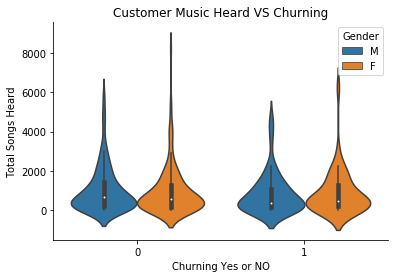

In [35]:
plot = sns.violinplot(data= customers_thumbs_up, x='churn', y='NextSong', hue='gender')
plt.xlabel('Churning Yes or NO')
plt.ylabel('Total Songs Heard')
plt.legend(title='Gender', loc='best')
plt.title('Customer Music Heard VS Churning')
sns.despine(ax= plot);

### Music Thumbs Up VS Churning

##### After the saturation point, those the churned users stopped liking new songs. Its a sign they did not like the music they were hearing.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


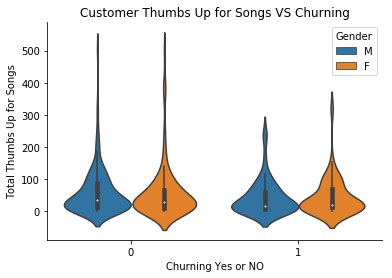

In [36]:
plot = sns.violinplot(data= customers_thumbs_up, x='churn', y='Thumbs Up', hue='gender')
plt.xlabel('Churning Yes or NO')
plt.ylabel('Total Thumbs Up for Songs')
plt.legend(title='Gender', loc='best')
plt.title('Customer Thumbs Up for Songs VS Churning')
sns.despine(ax= plot);

### Songs Added to Play List Made VS Churn Rate

##### The key to customer subcription is they stay engaged with new music suggestions and keep growing thier play list.
##### Males who churned stopped adding new songs to the play list early on. 
##### Payed customers keep growing thier play list.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


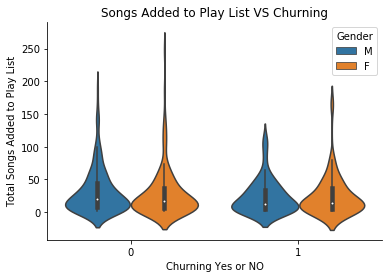

In [37]:
plot = sns.violinplot(data= customers_thumbs_up, x='churn', y='Add to Playlist', hue='gender')
plt.xlabel('Churning Yes or NO')
plt.ylabel('Total Songs Added to Play List')
plt.legend(title='Gender', loc='best')
plt.title('Songs Added to Play List VS Churning')
sns.despine(ax= plot);

### App logouts VS Churning

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


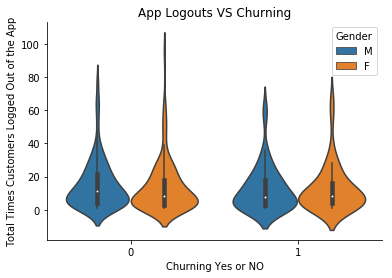

In [38]:
plot = sns.violinplot(data= customers_thumbs_up, x='churn', y='Logout', hue='gender')
plt.xlabel('Churning Yes or NO')
plt.ylabel('Total Times Customers Logged Out of the App')
plt.legend(title='Gender', loc='best')
plt.title('App Logouts VS Churning')
sns.despine(ax= plot);

### Churing VS Gender

##### Churn rate is higher in males compared to the subsciption ratio

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


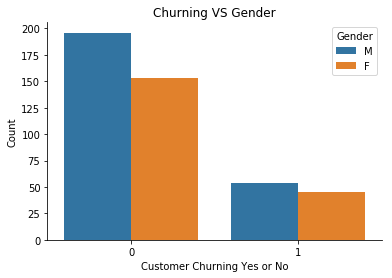

In [39]:

churn_gender = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

plot = sns.barplot(x='churn', y='count', hue='gender', data= churn_gender)
plt.xlabel('Customer Churning Yes or No')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Churning VS Gender')
sns.despine(ax=plot)

### Customer Churning VS Songs Played Per Session

#### Subscribing customers played more songs per session

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


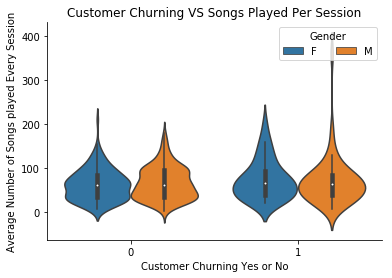

In [40]:
songs_count_by_gender = (df.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()
                   .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})
                   .withColumnRenamed('avg(count)', 'num_songs')
                   .toPandas())

plot = sns.violinplot('churn', y='num_songs', hue='gender', data= songs_count_by_gender)
plt.xlabel('Customer Churning Yes or No')
plt.ylabel('Average Number of Songs played Every Session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('Customer Churning VS Songs Played Per Session')
sns.despine(ax= plot);

### Customer Life Time VS Churn

##### Churned customers spent less time on Sparkify

In [41]:

lifetime_df = (df.select('userId','registration','ts','churn')
               .withColumn('lifetime',(df.ts - df.registration))
               .groupBy('userId','churn')
               .agg({'lifetime':'avg'})
               .withColumnRenamed('avg(lifetime)','lifetime')
               .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime'))
               .toPandas())

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


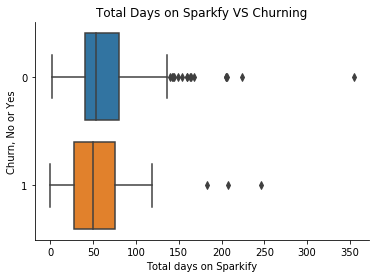

In [42]:

plot = sns.boxplot(data = lifetime_df, y='churn', x='lifetime', orient='h')
plt.xlabel('Total days on Sparkify')
plt.ylabel('Churn, No or Yes')
plt.title('Total Days on Sparkfy VS Churning')
sns.despine(ax= plot);

### Feature Creation

In [43]:
df_py = df.toPandas()

In [44]:
df_py.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,upgrade_event,upgraded_before,upgrade_confirmed,downgrade_event,downgrade,churn_event,churn
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,0,0,1


In [52]:
df_py.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId',
       'upgrade_event', 'upgraded_before', 'upgrade_confirmed',
       'downgrade_event', 'downgrade', 'churn_event', 'churn'],
      dtype='object')

##### Total number of Artist listened by each Customer 

In [45]:
# Number of artists listened
total_artist_listened = (df.filter(df.page=="NextSong")
                        .select("userId", "artist")
                        .dropDuplicates()
                        .groupby("userId")
                        .count()
                        .withColumnRenamed("count", "artist_count"))

total_artist_listened.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|658.9799107142857|
| stddev|105964.58428485187|625.8826980519572|
|    min|                10|                1|
|    max|                99|             3507|
+-------+------------------+-----------------+



##### Turning Gender to Binary - Hot Encoding

In [55]:
gender = (df.select("userId", "gender")
          .dropDuplicates()
          .replace(['M', 'F'], ['0', '1'], 'gender')
          .select('userId', col('gender').cast('int')))

gender.describe().show()

+-------+------------------+------------------+
|summary|            userId|            gender|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.4419642857142857|
| stddev|105964.58428485184|0.4971756279079037|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



##### Total Music Heard 

In [56]:
# Total length of listening
total_length_music = (df.select('userId','length')
                      .groupBy('userId')
                      .sum()
                      .withColumnRenamed('sum(length)', 'total_music_listened'))

total_length_music.describe().show()

+-------+------------------+--------------------+
|summary|            userId|total_music_listened|
+-------+------------------+--------------------+
|  count|               448|                 448|
|   mean| 67520.34821428571|  240270.49760906244|
| stddev|105964.58428485181|  286257.95260453096|
|    min|                10|           131.00363|
|    max|                99|   2019435.103940004|
+-------+------------------+--------------------+



##### Subscription Level

In [57]:
subscription = (df.select("userId", "level", "ts")
                .orderBy('ts', ascending = False)
                .dropDuplicates(['userId'])
                .replace(['free', 'paid'], ['0', '1'], 'level')
                .select('userId', col('level').cast('int'))
                .withColumnRenamed('level', 'subscription')
               )

subscription.describe().show()

+-------+------------------+------------------+
|summary|            userId|      subscription|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.5848214285714286|
| stddev|105964.58428485187|0.4933036731083654|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



#### Feature Creation for column Page

In [50]:
df_py.page.unique()

array(['NextSong', 'Roll Advert', 'Home', 'Thumbs Up', 'Thumbs Down',
       'Add Friend', 'Add to Playlist', 'Logout', 'Upgrade', 'Cancel',
       'Cancellation Confirmation', 'Help', 'About', 'Submit Upgrade',
       'Downgrade', 'Settings', 'Save Settings', 'Error',
       'Submit Downgrade'], dtype=object)

##### Total Songs heard

In [66]:
# Total songs listened

total_songs_listened = (df.select('userId','page')
                           .where(df.page == '')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'songs_added_to_playlist'))

total_songs_listened.describe().show()

+-------+------------------+--------------------+
|summary|            userId|total_songs_listened|
+-------+------------------+--------------------+
|  count|               448|                 448|
|   mean| 67520.34821428571|  1178.5825892857142|
| stddev|105964.58428485187|  1380.6279647524045|
|    min|                10|                   3|
|    max|                99|                9767|
+-------+------------------+--------------------+



###### Total Songs Heard Per Session

In [68]:
songs_listened_per_session = (df.select('userId','song')
                              .groupBy('userId')
                              .count()
                              .withColumnRenamed('count', 'total_songs_listened'))

songs_listened_per_session.describe().show()

AnalysisException: "cannot resolve '`sessionId`' given input columns: [userId, page];;\n'Aggregate [userId#23, 'sessionId], [userId#23, 'sessionId, count(1) AS count#3064L]\n+- Filter (page#16 = NextSong)\n   +- Project [userId#23, page#16]\n      +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427, downgrade#451, churn_event#475, churn#501]\n         +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427, downgrade#451, churn_event#475, ... 2 more fields]\n            +- Window [max(churn_event#475) windowspecdefinition(userId#23, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS churn#501], [userId#23]\n               +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427, downgrade#451, churn_event#475]\n                  +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427, downgrade#451, <lambda>(page#16) AS churn_event#475]\n                     +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427, downgrade#451]\n                        +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427, downgrade#451, downgrade#451]\n                           +- Window [max(downgrade_event#427) windowspecdefinition(userId#23, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS downgrade#451], [userId#23]\n                              +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, downgrade_event#427]\n                                 +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgrade_confirmed#385, <lambda>(page#16) AS downgrade_event#427]\n                                    +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, <lambda>(page#16) AS upgrade_confirmed#385]\n                                       +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364]\n                                          +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343, upgraded_before#364, upgraded_before#364]\n                                             +- Window [max(upgrade_event#343) windowspecdefinition(userId#23, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS upgraded_before#364], [userId#23]\n                                                +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, upgrade_event#343]\n                                                   +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, <lambda>(page#16) AS upgrade_event#343]\n                                                      +- Filter NOT (userId#23 = )\n                                                         +- Filter AtLeastNNulls(n, userId#23,sessionId#18L)\n                                                            +- Relation[artist#6,auth#7,firstName#8,gender#9,itemInSession#10L,lastName#11,length#12,level#13,location#14,method#15,page#16,registration#17L,sessionId#18L,song#19,status#20L,ts#21L,userAgent#22,userId#23] json\n"

##### Total Songs added to Playlist

In [60]:
songs_added_to_playlist = (df.select('userId','page')
                           .where(df.page == 'Add to Playlist')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'songs_added_to_playlist'))

songs_added_to_playlist.describe().show()

+-------+------------------+-----------------------+
|summary|            userId|songs_added_to_playlist|
+-------+------------------+-----------------------+
|  count|               428|                    428|
|   mean| 65764.93457943926|     28.852803738317757|
| stddev|105363.38578382801|      33.91309069456629|
|    min|                10|                      1|
|    max|                99|                    248|
+-------+------------------+-----------------------+



##### Total Thumbs Up & Thumbs Down

In [61]:
total_thumbs_up = (df.select('userId','page')
                           .where(df.page == 'Thumbs Up')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'total_thumbs_up'))

total_thumbs_up.describe().show()

+-------+------------------+-----------------+
|summary|            userId|  total_thumbs_up|
+-------+------------------+-----------------+
|  count|               439|              439|
|   mean| 67308.81548974942|54.27334851936219|
| stddev|106228.80408254788|69.94135178778986|
|    min|                10|                1|
|    max|                99|              506|
+-------+------------------+-----------------+



In [73]:
total_thumbs_down = (df.select('userId','page')
                           .where(df.page == 'Thumbs Down')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'total_thumbs_down'))

total_thumbs_down.describe().show()

+-------+-----------------+------------------+
|summary|           userId| total_thumbs_down|
+-------+-----------------+------------------+
|  count|              389|               389|
|   mean|70031.19537275065|12.624678663239074|
| stddev|106895.7373531136|13.582432851937991|
|    min|               10|                 1|
|    max|               99|                80|
+-------+-----------------+------------------+



#### Total Upgrades & Downgrades

In [74]:
subscription_upgrade = (df.select('userId','page')
                           .where(df.page == 'Upgrade')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'subscription_upgrade'))

subscription_upgrade.describe().show()

+-------+------------------+--------------------+
|summary|            userId|subscription_upgrade|
+-------+------------------+--------------------+
|  count|               315|                 315|
|   mean|62333.184126984124|   3.073015873015873|
| stddev|100904.14441579918|  2.5271271136988402|
|    min|               100|                   1|
|    max|                99|                  16|
+-------+------------------+--------------------+



In [75]:
subscription_downgrade = (df.select('userId','page')
                           .where(df.page == 'Downgrade')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'subscription_downgrade'))

subscription_downgrade.describe().show()

+-------+------------------+----------------------+
|summary|            userId|subscription_downgrade|
+-------+------------------+----------------------+
|  count|               301|                   301|
|   mean| 69214.00332225913|    12.661129568106313|
| stddev|109835.16929944005|    12.522970256818317|
|    min|                10|                     1|
|    max|                99|                    85|
+-------+------------------+----------------------+



In [77]:
subscription_submit_upgrade = (df.select('userId','page')
                           .where(df.page == 'Submit Upgrade')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'subscription_submit_upgrade'))

subscription_submit_upgrade.describe().show()

+-------+-----------------+---------------------------+
|summary|           userId|subscription_submit_upgrade|
+-------+-----------------+---------------------------+
|  count|              233|                        233|
|   mean|66206.63519313304|         1.2317596566523605|
| stddev|107468.1440963255|         0.4890392522711758|
|    min|              100|                          1|
|    max|               99|                          3|
+-------+-----------------+---------------------------+



In [76]:
subscription_submit_downgrade = (df.select('userId','page')
                           .where(df.page == 'Submit Downgrade')
                           .groupBy('userId')
                           .count()
                           .withColumnRenamed('count', 'subscription_submit_downgrade'))

subscription_submit_downgrade.describe().show()

+-------+------------------+-----------------------------+
|summary|            userId|subscription_submit_downgrade|
+-------+------------------+-----------------------------+
|  count|                97|                           97|
|   mean| 69180.93814432989|           1.2061855670103092|
| stddev|100315.97150294397|           0.4315221201817881|
|    min|            100002|                            1|
|    max|                99|                            3|
+-------+------------------+-----------------------------+



Py4JJavaError: An error occurred while calling o1015.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 150.0 failed 4 times, most recent failure: Lost task 0.3 in stage 150.0 (TID 10752, 172.30.163.161, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/worker.py", line 74, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-11-7051b7f4c77d>", line 3, in <lambda>
NameError: name 'datetime' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1160)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.lang.Thread.run(Thread.java:811)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:3195)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:3225)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3192)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:90)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:508)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:811)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/ibm/spark/python/lib/pyspark.zip/pyspark/worker.py", line 74, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-11-7051b7f4c77d>", line 3, in <lambda>
NameError: name 'datetime' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1160)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
